<a href="https://colab.research.google.com/github/andryD-ai/ChatBot/blob/main/LLM_Chatbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Download dataset and minbpe

In [1]:
# !pip install datasets

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/
%mkdir /content/model/

/content


In [4]:
%cd /content/model/
%mkdir /content/model/data/
%cd /content/model/data/

/content/model
/content/model/data


In [5]:
# from datasets import load_dataset

# # Load the IMDB dataset
# imdb_dataset = load_dataset("MohammadOthman/mo-customer-support-tweets-945k")

In [6]:
# # Check the dataset structure
# print(imdb_dataset)

# # Access the training, testing, and validation sets
# train_data = imdb_dataset['train']

# # View a sample from the training data
# print(train_data[0])

In [7]:
# from tqdm import tqdm

# tab_token = " \t "
# enter_token = " \n"

# chat_data = []

# for data in tqdm(train_data):
#   chat_data.append(data['input'] + tab_token + data['output'] + enter_token)

In [8]:
data_path = "/content/drive/MyDrive/Dataset/Chat_Dataset/mo-customer-support-tweets-945k.txt"
# with open(data_path, "w") as f:
#   f.write(" ".join(chat_data))

In [9]:
# Small dataset
# !wget   https://www.kaggle.com/api/v1/datasets/download/grafstor/simple-dialogs-for-chatbot
# !unzip /content/model/data/simple-dialogs-for-chatbot
# !rm -r /content/model/data/simple-dialogs-for-chatbot
# %cd /content/model/data/

In [10]:
!git clone https://github.com/karpathy/minbpe.git

Cloning into 'minbpe'...
remote: Enumerating objects: 217, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 217 (delta 102), reused 87 (delta 87), pack-reused 93 (from 2)
Receiving objects: 100% (217/217), 335.66 KiB | 1.30 MiB/s, done.
Resolving deltas: 100% (128/128), done.


## Tokenization and fine-tuning data


In [11]:
%cd /content/model/

/content/model


In [12]:
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 17.6 MB/s eta 0:00:00


In [17]:
from model.data.minbpe.minbpe import BasicTokenizer


# with open(data_path, "r") as f:
#     num_of_charas_to_read = 10000000
#     text_sequence = f.read(num_of_charas_to_read)

# #Train BPE
# tokenizer = BasicTokenizer()
# tokenizer.train(text_sequence, vocab_size=16384)

In [59]:
# #Add special token
# max_vocab_id = list(tokenizer.vocab.keys())[-1]
# tokenizer.special_tokens = {
#     "<|startoftext|>": max_vocab_id + 1,
#     "<|separator|>": max_vocab_id + 2,
#     "<|endoftext|>": max_vocab_id + 3,
#     "<|unk|>": max_vocab_id + 4
# }

In [9]:
# !mkdir /content/model/data/tokenizer

In [14]:
path_tokenizer = "/content/drive/MyDrive/Dataset/Chat_Dataset/mo-customer-support-tweets-945k_token"
# tokenizer.save(file_prefix=path_tokenizer)

In [15]:
from model.data.minbpe.minbpe import RegexTokenizer

path_tokenizer = path_tokenizer + ".model"

tokenizer = RegexTokenizer()
tokenizer.load(model_file=path_tokenizer)


In [18]:
def get_vocab_size(tokenizer: BasicTokenizer) -> int:
    vocab = tokenizer.vocab
    special_tokens = tokenizer.special_tokens

    return len(vocab) + len(special_tokens)

In [19]:
#Add special_tokens to dataset and tokenized the sequences

with open(data_path, "r", encoding="utf-8") as f:
  lines = f.readlines()

tab_token = "\t"
enter_token = "\n"

start_of_text_token = "<|startoftext|>"
end_of_text_token = "<|endoftext|>"
separator_token = "<|separator|>"

tokenized_data = []
fine_tuning_dataa =[]
for line in lines:
  line = line.replace(tab_token, separator_token).strip()
  line = line.replace(enter_token, "").strip()

  #fine-tuning data
  fine_tuning_data = f"{start_of_text_token}{line}{end_of_text_token}"
  fine_tuning_dataa.append(fine_tuning_data)
  #tokenized the sequences
  tokenized_data.append(tokenizer.encode(fine_tuning_data, allowed_special = "all"))


##Create train, val data

In [20]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [21]:
#Create train data and val data
initial_split_index = int(0.8*len(tokenized_data))

train_data = tokenized_data[:initial_split_index]
val_data = tokenized_data[initial_split_index:]

In [22]:
#Combine mess to block_size

block_size = 256

def merge_conversation_to_block_size(data: list[list[int]], block_size: int):
  '''
  data: tokenized conversation list
  block_size: size of block
  '''
  max = 0
  new_convers = []
  cur_conver = []
  for cover in data:
    if len(cur_conver) + len(cover) <= block_size:
      cur_conver.extend(cover)
    else:
      if cur_conver:
        new_convers.append(cur_conver)
        if max < len(cur_conver):
          max = len(cur_conver)
      cur_conver = cover.copy()

  if cur_conver:
    new_convers.append(cur_conver)
  return new_convers

train_data = merge_conversation_to_block_size(train_data, block_size)
val_data = merge_conversation_to_block_size(val_data, block_size)

In [23]:
#padding data

import torch
torch.manual_seed(3647)
import torch.nn as nn
from torch.nn import functional as F


def padding_data(data: list[list[int]], padding: int) -> torch.Tensor:
  '''
  data: tokenized conversation list
  padding: padding index
  '''

  tensors = []

  for index in range(len(data)):
    tensor = torch.tensor(data[index])
    padded_tensor = F.pad(
        input=tensor,
        pad=(0, block_size - len(tensor)),
        value=padding
    )
    tensors.append(padded_tensor)

  return torch.stack(tensors)

padding_token = -100

train_data = padding_data(train_data, padding_token)
val_data = padding_data(val_data, padding_token)

In [24]:
from typing import Tuple
from torch.utils.data import Dataset, DataLoader


class FineTuningDataset(Dataset):
    def __init__(self, data: torch.Tensor, device: torch.device, padding_token: int):
        self.data = data  # shape: (num_samples, block_size)
        self.device = device
        self.padding_token = padding_token

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        sample = self.data[index]
        x = sample.to(self.device)
        y = sample[1:].to(self.device)
        padding_tensor = torch.tensor([self.padding_token], device=self.device)
        y = torch.cat((y, padding_tensor))
        return x, y


batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = FineTuningDataset(
    data=train_data,
    device=device,
    padding_token=padding_token
)
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_dataset = FineTuningDataset(
    data=val_data,
    device=device,
    padding_token=padding_token
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False
)

In [25]:
x, y = next(iter(val_loader))
x.shape, y.shape

(torch.Size([32, 256]), torch.Size([32, 256]))

##Transformer

In [29]:

class Head(nn.Module):
  '''One head of self-attention'''

  def __init__(self, head_size: int) -> None:
    super().__init__()
    self.query = nn.Linear(num_embd, head_size, bias=False)
    self.key = nn.Linear(num_embd, head_size, bias=False)
    self.value = nn.Linear(num_embd, head_size, bias=False)
    self.register_buffer('tril', torch.tril(torch.ones(block_size,block_size)))

    self.dropout = nn.Dropout(dropout)

  def forward(self, x:torch.Tensor) -> torch.Tensor:
    # input of size (batch, block_size (time-step), num_embd (Channel))
    # output of size (batch, block_size (time-step), head size)
    _, T, _ = x.shape
    q = self.query(x) # (B,bs,hs)
    k = self.key(x)   # (B,bs,hs)
    # compute attention scores ("affinities")
    # (B, bs, hs) @ (B, hs, bs) -> (B, bs, bs)
    weights = q @ k.transpose(-2, -1) * k.shape[-1]**-0.5
    weights = weights.masked_fill(
        self.tril[:T, :T] == 0, float('-inf'))  # (B, bs, bs)
    weights = F.softmax(weights, dim=-1)  # (B, bs, bs)
    weights = self.dropout(weights)
    # perform the weighted aggregation of the values
    v = self.value(x)  # (B,bs,hs)
    out = weights @ v  # (B, bs, bs) @ (B, bs, hs) -> (B, bs, hs)
    return out

In [30]:
from typing import Optional, Tuple

class MultiHeadAttention(nn.Module):
  def __init__(self, num_head: int, head_size: int) -> None:
    super().__init__()
    self.heads = nn.ModuleList([Head(head_size) for _ in range(num_head)])
    self.projection = nn.Linear(num_head * head_size, num_embd)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    output = torch.cat([h(x) for h in self.heads], dim=-1)
    output = self.projection(output)
    return self.dropout(output)

class FeedFoward(nn.Module):
  def __init__(self, num_embd) -> None:
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(num_embd, num_embd * 4),
        nn.ReLU(),
        nn.Linear(num_embd * 4, num_embd),
        nn.Dropout(dropout),
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.net(x)

class Block(nn.Module):
  def __init__(self, num_head: int, num_embd: int) -> None:
    super().__init__()
    head_size = num_embd // num_head
    self.self_attention = MultiHeadAttention(num_head, head_size)
    self.feed_forward = FeedFoward(num_embd)
    self.layer_nom1 = nn.LayerNorm(num_embd)
    self.layer_nom2 = nn.LayerNorm(num_embd)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    output = x + self.layer_nom1(self.self_attention(x))
    output = output + self.layer_nom2(self.feed_forward(output))
    return output

class LLM(nn.Module):

  def __init__(self) -> None:
    super().__init__()

    self.tokens_embdding = nn.Embedding(vocab_size, num_embd)
    self.position_embdding = nn.Embedding(block_size, num_embd)
    self.blocks = nn.Sequential(
        *[Block(num_head, num_embd) for _ in range(num_layer)]
    )
    self.layer_nom = nn.LayerNorm(num_embd)
    self.last_linear = nn.Linear(num_embd, vocab_size)

    self.apply(self._init_weights)

  def _init_weights(self, module: nn.Module) -> None:
    if isinstance(module, nn.Linear):
        torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        if module.bias is not None:
            torch.nn.init.zeros_(module.bias)
    elif isinstance(module, nn.Embedding):
        torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

  def forward(self, input_tokens: torch.Tensor, targets: Optional[torch.Tensor] = None) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:

    B, T = input_tokens.shape
    token_embdding = self.tokens_embdding(input_tokens)
    positional_embedding = self.position_embdding(
        torch.arange(T, device=device)
    )

    x = token_embdding + positional_embedding
    x = self.blocks(x)
    x = self.layer_nom(x)
    logits = self.last_linear(x)

    if targets is None:
      loss = None
    else:
      B, T, C = logits.shape
      logits = logits.view(B*T, C)
      targets = targets.view(B*T)
      loss = F.cross_entropy(logits, targets)

    return logits, loss

  def generate(self, input_tokens: torch.Tensor, max_new_tokens: int) -> torch.Tensor:
        """
                Generate new tokens given a context.

                Args:>ns: Starting token indices of shape (batch_size, sequence_length)
                        max_new_tokens: Number of new tokens to generate

                Returns:
                        Tensor of token indices of shape (batch_size, sequence_length + max_new_tokens)
                """

        # input_tokens is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop input_tokens to the last block_size tokens
            cropped_input = input_tokens[:, -block_size:]
            # get the predictions
            logits, _ = self(cropped_input)
            # focus only on the last time step
            logits = logits[:, -1, :]  # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1)  # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (B, 1)
            # append sampled index to the running sequence
            input_tokens = torch.cat(
                (input_tokens, idx_next), dim=1)  # (B, T+1)
        return input_tokens


##Traning


In [31]:
#Parameters

num_embd = 1024
num_head = 16
block_size = 256
dropout = 0.2
vocab_size = get_vocab_size(tokenizer)
num_layer = 4
batch_size = 64

model = LLM().to(device)
model = torch.compile(model)

In [32]:
from typing import Dict


@torch.no_grad()
def estimate_loss(
    model: torch.nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    eval_iters: int
) -> Dict[str, float]:
    output = {}
    model.eval()

    for split, loader in [('train', train_loader), ('val', val_loader)]:
        losses = torch.zeros(eval_iters)
        for i, (x, y) in enumerate(loader):
            if i >= eval_iters:
                break
            with torch.no_grad():
                _, loss = model(x, y)
            losses[i] = loss.item()
        output[split] = losses.mean().item()

    model.train()
    return output

In [33]:
def save_checkpoint(
    model: LLM,
    optimizer: torch.optim.Optimizer,
    epoch: int,
    loss: float,
    file_path: str = "checkpoint.pth"
) -> None:
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, file_path)

In [34]:
%rm -r /content/model/output/
%mkdir /content/model/output/

rm: cannot remove '/content/model/output/': No such file or directory


In [35]:
max_iters = 1
eval_interval = 100
eval_iters = 200
learning_rate = 3e-4

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []

for iteration in range(max_iters):
    for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
        # Evaluation
        if batch_idx % eval_interval == 0 or batch_idx == len(train_loader) - 1:
            losses = estimate_loss(
                model=model,
                train_loader=train_loader,
                val_loader=val_loader,
                eval_iters=min(eval_iters, len(val_loader))
            )
            train_losses.append(losses['train'])
            val_losses.append(losses['val'])

            print(
                f"iteration {iteration} / step {batch_idx}: "
                f"train loss {losses['train']:.4f}, "
                f"val loss {losses['val']:.4f}"
            )

        # Training step
        logits, loss = model(x_batch, y_batch)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    # Save checkpoint
    save_checkpoint(
        model=model,
        optimizer=optimizer,
        epoch=iteration,
        loss=loss.item(),
        file_path=f"/content/model/output/checkpoint_{iteration}.pth"
    )

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


iteration 0 / step 0: train loss 6.0345, val loss 6.0373


KeyboardInterrupt: 

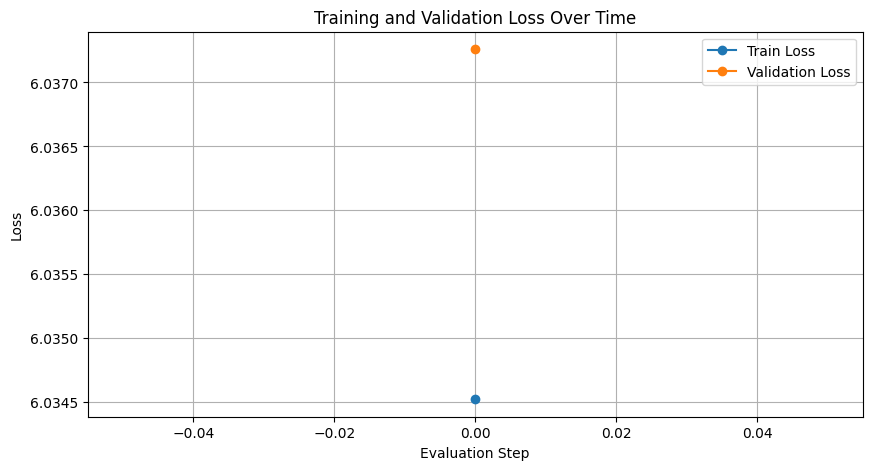

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss", marker='o')
plt.plot(val_losses, label="Validation Loss", marker='o')
plt.xlabel("Evaluation Step")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Time")
plt.legend()
plt.grid()
plt.show()

In [37]:
input_tokens = tokenizer.encode("where are you?")
input_tokens = torch.tensor(
    input_tokens, dtype=torch.long).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output = model.generate(input_tokens=input_tokens, max_new_tokens=100)

print(tokenizer.decode(output[0].tolist()))

where are you?oislra�rbo|rV�!riaoniirbr�yn0o\esise*sisnknitmoaoitkdisg�ifrn�ip�noaisOatua�ihikrsiniooB1hniilhnsrc
